In [ ]:

import numpy as np
import pandas as pd
from pandas import Series,DataFrame
df = pd.read_csv("Hotels_data_Changed.csv")

**Filtering the Top 150 Most Frequent Hotels**

This script processes hotel data by selecting the 150 most frequently occurring hotels in the dataset.
- **Count Hotel Occurrences**: The script counts the number of occurrences of each hotel using the `groupby` and `transform` functions.
- **Select Top 150**: The dataset is filtered to include only the top 150 most frequent hotels based on their count.
- **Filter Dataset**: The filtered dataset contains only the most frequent 150 hotels, and this filtered data is stored in the `most_common_hotels` variable for further processing.


In [ ]:
df["Hotel_Count"] = df.groupby('Hotel Name')['Hotel Name'].transform('count')
descending_hotels = df.sort_values(by=['Hotel_Count'],ascending=False).reset_index()

df_hotels = descending_hotels["Hotel Name"].unique()[:150]
most_common_hotels = descending_hotels[descending_hotels['Hotel Name'].isin(df_hotels)]

**Filtering the Top 40 Most Frequent Check-in Dates**

This script refines the hotel dataset by selecting the 40 most frequently occurring check-in dates.
- **Count Check-in Date Occurrences**: The script counts the number of occurrences of each check-in date using the `groupby` and `transform` functions.
- **Select Top 40**: The dataset is filtered to include only the top 40 most frequent check-in dates, based on their count.
- **Filter Dataset**: The filtered dataset contains only the most frequent 40 check-in dates, which are stored in the `most_common_hotels` variable for further processing. This ensures that further analysis focuses on the most commonly booked dates, making trend detection and pricing analysis more relevant.


In [ ]:
most_common_hotels.loc[:, "Checkin_Count"] = most_common_hotels.groupby('Checkin Date')['Checkin Date'].transform('count')
descending_most_common_hotels = most_common_hotels.sort_values(by=['Checkin_Count'],ascending=False).reset_index()

common_checkins_list = descending_most_common_hotels["Checkin Date"].unique()[:40]
most_checkins = descending_most_common_hotels[descending_most_common_hotels['Checkin Date'].isin(common_checkins_list)]

**Generating All Combinations of Hotel Names, Check-in Dates, and Discount Codes**

In this step, we are creating all possible combinations of `Hotel Name`, `Check-in Date`, and `Discount Code`:
- **Unique Hotel Names**: We get the list of unique hotel names from the dataset.
- **Unique Check-in Dates**: We get the list of unique check-in dates.
- **Unique Discount Codes**: A predefined list of discount codes is provided (`[1, 2, 3, 4]`).

The **combinations** of these three elements are generated using a nested loop, and each combination is appended to the list `combs`. This helps in creating a structure that will later be added to the dataset. Finally, this new list is converted into a DataFrame and concatenated with the original `most_checkins` DataFrame, adding all possible combinations to the dataset for further analysis.

This approach ensures that we have all combinations of hotels, check-in dates, and discount codes, providing a complete view of potential data interactions.


In [ ]:
import pandas as pd
import sys

unique_hotels_names = most_checkins["Hotel Name"].unique()
unique_checkins =  most_checkins["Checkin Date"].unique()
unique_discount_code =  [1,2,3,4]
combs = []
for x in unique_hotels_names:
    for y in unique_checkins:
        for z in unique_discount_code:
            combs.append([x, y, z, sys.maxsize])

new_df = pd.DataFrame(combs, columns=["Hotel Name", "Checkin Date", "Discount Code", "Discount Price"])

most_checkins = pd.concat([most_checkins, new_df], ignore_index=True)


**Finding Minimum Discount Price for Each Hotel and Check-in Date Combination**

In this step, we process the `most_checkins` dataset by calculating the **minimum discount price** for each unique combination of `Hotel Name`, `Check-in Date`, and `Discount Code`:
- **Grouping by Columns**: We group the data by `Hotel Name`, `Check-in Date`, and `Discount Code` to find the minimum discount price for each combination.
- **Dropping Duplicates**: After calculating the minimum, we drop duplicates to ensure each combination appears only once.
- **Sorting**: We sort the dataset by `Hotel Name`, `Check-in Date`, and `Discount Code` to make sure the data is ordered logically.
- **Replacing Maximum Value**: Any remaining missing values in the discount price column are replaced with the maximum possible value (`sys.maxsize`), which represents the largest integer value, ensuring no negative or non-numeric values.

Finally, the relevant columns `Hotel Name`, `Check-in Date`, `Discount Code`, and `Discount Price` are selected and the DataFrame is reset for further analysis.

This step prepares the dataset by ensuring that the discount price for each hotel, check-in date, and discount code combination is valid and consistent.


In [ ]:
most_checkins["Discount Price"] = most_checkins.groupby(
    ['Hotel Name', 'Checkin Date', 'Discount Code'])["Discount Price"].transform('min')

most_checkins = most_checkins.drop_duplicates(subset=["Hotel Name", "Checkin Date", "Discount Code"])
most_checkins = most_checkins.sort_values(by=["Hotel Name", "Checkin Date", "Discount Code"], ascending=True)
most_checkins["Discount Price"] = most_checkins["Discount Price"].replace(sys.maxsize, -1)

checkin_hotel_discount = most_checkins[["Hotel Name", "Checkin Date", "Discount Code", "Discount Price"]].reset_index()


### **Normalizing Discount Price Data**
In this step, we process the `Discount Price` column by normalizing it using min-max normalization, specifically for values greater than -1. This ensures that we only work with valid data while disregarding invalid values (e.g., values lower than -1).

The **normalization formula** is:

\[
\text{Normalized Value} = \frac{(\text{Original Value} - \text{Min Value})}{(\text{Max Value} - \text{Min Value})} \times 100
\]

This formula scales each `Discount Price` value between 0 and 100 based on the minimum and maximum values in the dataset for each hotel. The normalization is applied per hotel (grouped by `Hotel Name`), ensuring that the data is transformed relative to each hotel's specific price range.

- **Filtering Invalid Data:** We also filter out values where the `Discount Price` is less than or equal to -1, as they represent invalid data.
  
- **Concatenation and Sorting:** After the normalization, the synthesized data is concatenated with the original dataset, and the final dataframe is sorted by `Hotel Name`, `Checkin Date`, and `Discount Code` for better structure and consistency.

This normalization process ensures that the `Discount Price` values are comparable across different hotels, making them ready for further analysis or modeling.


In [ ]:
discount_filtered = checkin_hotel_discount[checkin_hotel_discount['Discount Price'] > -1 ]

def normalize_data(x):
    diff = max(x) - min(x)
    if(diff == 0):
        return 0
    else:
        return (round( ( x - min(x) ) / ( max(x) - min(x) ) * 100 ))
pd.set_option('mode.chained_assignment', None)

discount_filtered_grouped = discount_filtered.groupby('Hotel Name')['Discount Price']
discount_filtered["Normal"] = discount_filtered_grouped.transform(normalize_data)

discount_synth = checkin_hotel_discount[checkin_hotel_discount['Discount Price'] == -1 ]
discount_synth["Normal"] = -1


normal_dataFrame = pd.concat([discount_synth, discount_filtered], ignore_index=True)
normal_dataFrame.sort_values(by=["Hotel Name", "Checkin Date", "Discount Code"], ascending=True, inplace=True)
normal_dataFrame


,index,Hotel Name,Checkin Date,Discount Code,Discount Price,Normal
0,27920,1 Hotel Central Park,10/1/2015 0:00,1.0,-1.0,-1.0
1,27921,1 Hotel Central Park,10/1/2015 0:00,2.0,-1.0,-1.0
2,27922,1 Hotel Central Park,10/1/2015 0:00,3.0,-1.0,-1.0
3,27923,1 Hotel Central Park,10/1/2015 0:00,4.0,-1.0,-1.0
4,27932,1 Hotel Central Park,10/2/2015 0:00,1.0,-1.0,-1.0
...,...,...,...,...,...,...
19102,36983,the Quin,9/8/2015 0:00,4.0,-1.0,-1.0
19103,36936,the Quin,9/9/2015 0:00,1.0,-1.0,-1.0
19104,36937,the Quin,9/9/2015 0:00,2.0,-1.0,-1.0
19105,36938,the Quin,9/9/2015 0:00,3.0,-1.0,-1.0


### **Creating Rows with Grouped Data**
In this step, we transform the `Normal` values for each hotel into a new format for further analysis.

1. **Creating a New Row Format:**
   The `createRow(x)` function converts each group's `Normal` values into a list, with the `Hotel Name` inserted at the beginning of the list.
   This ensures that each group of `Normal` values is associated with the respective hotel name.

2. **Appending Rows to a List:**
   The `new_list` containing the `Hotel Name` and its `Normal` values is then appended to a global list called `rows`. This operation is performed for each hotel group.

3. **Rebuilding DataFrame:**
   Finally, the `rows` list, which contains the transformed data, is converted back into a new DataFrame `vector` using `pd.DataFrame.from_records(rows)`. This results in a DataFrame where each row contains the hotel name and its corresponding normalized discount values.

This process is useful for restructuring the data in a way that facilitates analysis based on hotel groups and their respective normalized discount prices.


In [ ]:
rows = []
def createRow(x):
    new_list = x.tolist()
    new_list.insert(0,x.name)
    rows.append(new_list)

normal_dataFrame.groupby("Hotel Name")["Normal"].transform( createRow )
vector = pd.DataFrame.from_records(rows)

###Clustering Hotels Based on Pricing Strategies

In this step, we perform **hierarchical clustering** on the hotel dataset to identify hotels that exhibit similar pricing strategies. The goal is to group hotels that follow comparable pricing patterns, which can help in identifying common pricing behaviors across hotels. By understanding how different hotels apply their pricing strategies, we can identify potential trends and better forecast pricing patterns in the future.

#### Clustering Process:
1. **Count Check-in Occurrences**:
   - In this step, we calculate how often each hotel has check-ins for different dates. The number of check-ins on each day provides insight into how often hotels are booked, which indirectly correlates to their pricing behavior (e.g., frequent check-ins on certain dates may indicate higher pricing).
   
2. **Sort Data**:
   - Once we have the check-in data, we sort the dataset by **hotel name**, **check-in date**, and **discount code**. Sorting ensures the data is structured appropriately for the clustering process, as it allows for a more organized way of examining the relationships between pricing behaviors over time and across different hotels.
   
3. **Hierarchical Clustering**:
   - Here, we apply hierarchical clustering using the **'ward' method**, which minimizes the variance within each cluster. This method aims to create clusters where the hotels in each cluster exhibit similar pricing strategies. The results are visualized using a **dendrogram**, which shows the hierarchical relationships between the hotels based on the similarity of their pricing patterns.

#### Dendrogram Interpretation:
- The **dendrogram** helps visualize how hotels are grouped based on the similarity of their pricing strategies. The closer two hotels are in the dendrogram, the more similar their pricing strategies are. **Shorter vertical lines** in the dendrogram indicate that the two hotels in question have very similar pricing behavior, while **longer vertical lines** indicate that the pricing strategies of the hotels differ more significantly.
- By analyzing the dendrogram, we can determine which hotels have similar pricing patterns, which can be useful for market analysis, pricing optimization, and identifying competitive trends within the hospitality industry.


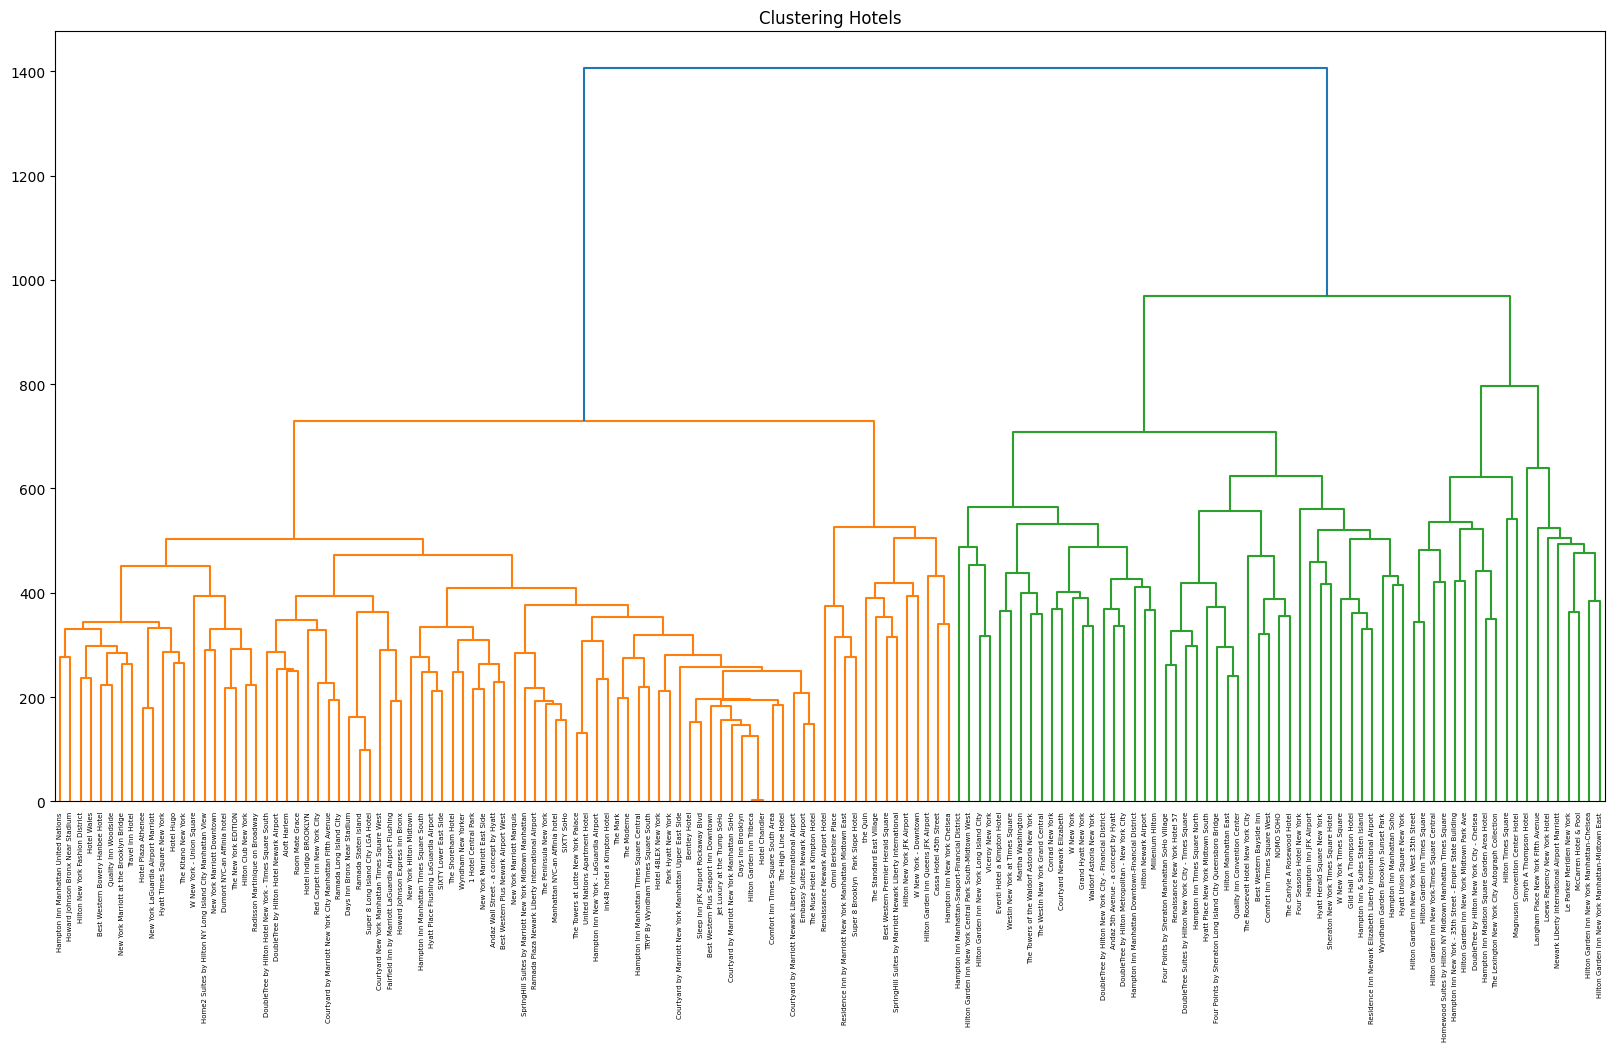

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy import cluster
shc = cluster.hierarchy

labels = vector.values[:,0]
data = vector.values[:,1:160]
plt.figure(figsize=(20, 10))
plt.title("Clustering Hotels")

Z = shc.linkage(data, method='ward')
dend = shc.dendrogram(Z, labels=labels)
plt.show(dend)